In [12]:
#importing all necessary libraries
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout,Input,Flatten,Dense,MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Data Augumentation
import os

In [2]:
tf.test.is_gpu_available() #checking for GPU

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [3]:
batchsize=8 #defining batch size


In [4]:
# Creating an ImageDataGenerator for training data with various augmentation techniques
train_datagen= ImageDataGenerator(rescale=1./255, rotation_range=0.2,shear_range=0.2,
    zoom_range=0.2,width_shift_range=0.2,
    height_shift_range=0.2, validation_split=0.2)

# Generating training data from the training directory
train_data= train_datagen.flow_from_directory(r"C:\Users\91877\Downloads\mrlEyes_2018_01\Train",target_size=(80,80),batch_size=batchsize,class_mode='categorical',subset='training' )

# Generating validation data from the training directory (subset for validation)
validation_data= train_datagen.flow_from_directory(r"C:\Users\91877\Downloads\mrlEyes_2018_01\Train",
                                target_size=(80,80),batch_size=batchsize,class_mode='categorical', subset='validation')

Found 64263 images belonging to 2 classes.
Found 16065 images belonging to 2 classes.


In [5]:
# Creating an ImageDataGenerator for test data with rescaling by 1./255
test_datagen = ImageDataGenerator(rescale=1./255)
# Generating data flow from the test directory
test_data = test_datagen.flow_from_directory(r"C:\Users\91877\Downloads\mrlEyes_2018_01\Test",
                                target_size=(80,80),batch_size=batchsize,class_mode='categorical') # Resizes the images to 80x80 pixels

Found 4570 images belonging to 2 classes.


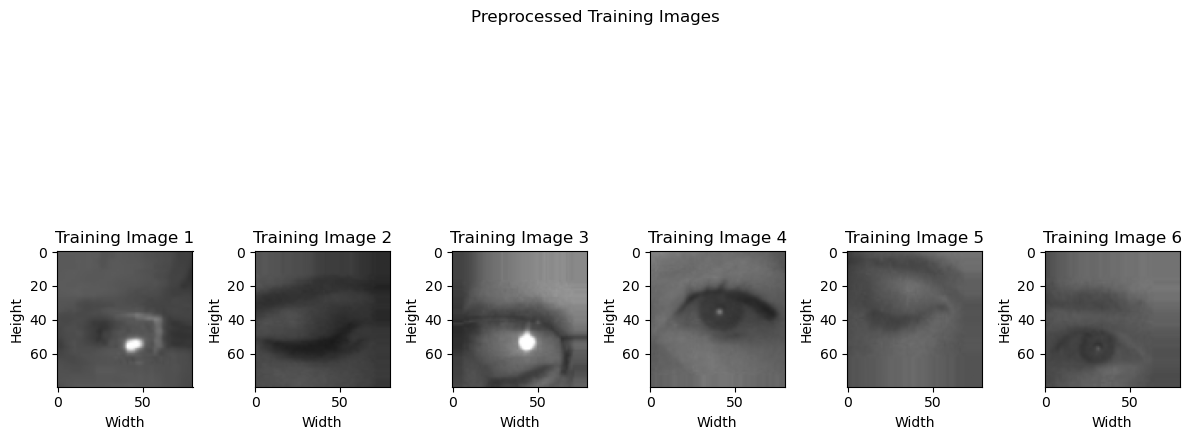

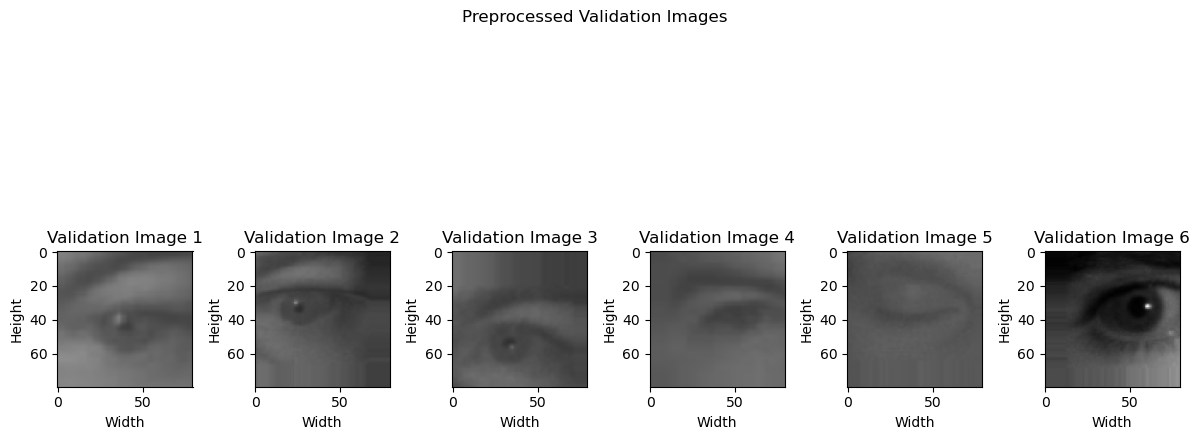

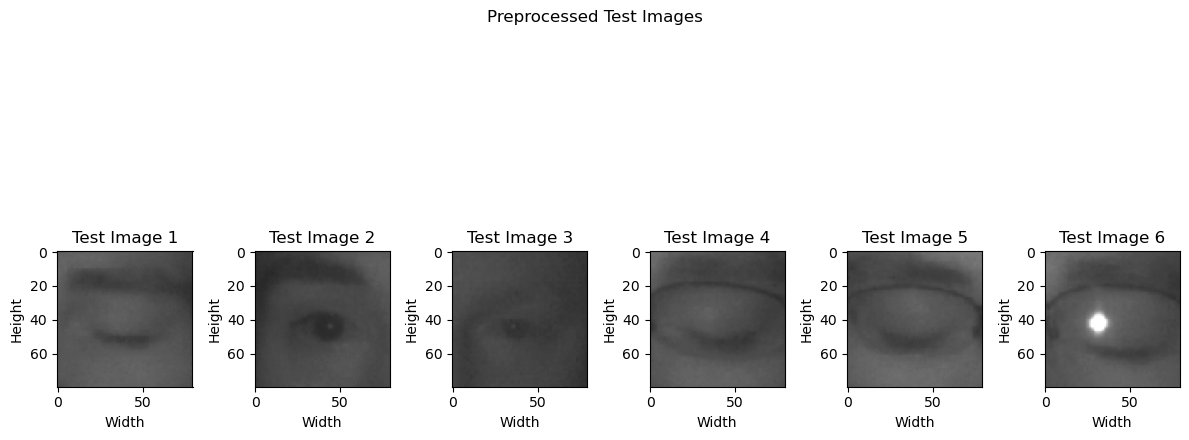

In [6]:
import matplotlib.pyplot as plt

def visualize_preprocessed_images(generator, num_images, dataset_type):
    plt.figure(figsize=(12, 6))   # Create a figure for visualizing the preprocessed images
    for i in range(num_images):
        batch = generator.next()
        image = batch[0][0]
        plt.subplot(1, num_images, i+1)
        plt.imshow(image)
        plt.xlabel('Width')
        plt.ylabel('Height')
        plt.axis('on')  # Show axis lines and labels
        plt.title(f"{dataset_type} Image {i+1}")
    plt.suptitle(f"Preprocessed {dataset_type} Images")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Visualizing preprocessed images
num_images_to_visualize = 6
visualize_preprocessed_images(train_data, num_images_to_visualize, 'Training')
visualize_preprocessed_images(validation_data, num_images_to_visualize, 'Validation')
visualize_preprocessed_images(test_data, num_images_to_visualize, 'Test')


# Model 1 

In [24]:
# Initializing the InceptionV3 model with pre-trained weights from ImageNet
bmodel = InceptionV3(include_top=False, weights='imagenet', input_tensor=Input(shape=(80,80,3)))
# Getting the output tensor of the base InceptionV3 model
hmodel = bmodel.output
# Flattening the output tensor
hmodel = Flatten()(hmodel)
# Adding a fully connected layer with 64 units and ReLU activation
hmodel = Dense(64, activation='relu')(hmodel)
# Adding a dropout layer to prevent overfitting
hmodel = Dropout(0.5)(hmodel)
# Adding the output layer with 2 units for binary classification (using softmax activation)
hmodel = Dense(2,activation= 'softmax')(hmodel)

# Creating a new model with the modified top layers (base model's input and modified output)
model = Model(inputs=bmodel.input, outputs= hmodel)
# Freezing the layers of the base InceptionV3 model to retain pre-trained weights.
for layer in bmodel.layers:
for layer in bmodel.layers:
    layer.trainable = False

87910968/87910968 [==============================] - 8s 0us/step


In [25]:
model.summary() #print model summary

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 80, 80, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 39, 39, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 39, 39, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 39, 39, 32)           0         ['batch_normalization[0][0

In [26]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau

In [29]:
checkpoint = ModelCheckpoint(r"C:\Users\91877\Downloads\mrlEyes_2018_01\Models\model.h5",
                            monitor='val_loss',save_best_only=True,verbose=3)

earlystop = EarlyStopping(monitor = 'val_loss', patience=7, verbose= 3, restore_best_weights=True)

learning_rate = ReduceLROnPlateau(monitor= 'val_loss', patience=3, verbose= 3, )

callbacks=[checkpoint,earlystop,learning_rate]

In [30]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=['accuracy'])

model.fit_generator(train_data,steps_per_epoch=train_data.samples//batchsize,
                   validation_data=validation_data,
                   validation_steps=validation_data.samples//batchsize,
                   callbacks=callbacks,
                    epochs=10)

C:\Users\91877\AppData\Local\Temp\ipykernel_9312\3037644191.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_data,steps_per_epoch=train_data.samples//batchsize,


Epoch 1/10
8032/8032 [==============================] - ETA: 0s - loss: 0.1606 - accuracy: 0.9386
Epoch 1: val_loss improved from inf to 0.17366, saving model to C:\Users\91877\Downloads\mrlEyes_2018_01\Models\model.h5


C:\Users\91877\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8032/8032 [==============================] - 638s 79ms/step - loss: 0.1606 - accuracy: 0.9386 - val_loss: 0.1737 - val_accuracy: 0.9286 - lr: 0.0010
Epoch 2/10
8032/8032 [==============================] - ETA: 0s - loss: 0.1536 - accuracy: 0.9427
Epoch 2: val_loss improved from 0.17366 to 0.17332, saving model to C:\Users\91877\Downloads\mrlEyes_2018_01\Models\model.h5
8032/8032 [==============================] - 625s 78ms/step - loss: 0.1536 - accuracy: 0.9427 - val_loss: 0.1733 - val_accuracy: 0.9310 - lr: 0.0010
Epoch 3/10
8032/8032 [==============================] - ETA: 0s - loss: 0.1550 - accuracy: 0.9407
Epoch 3: val_loss did not improve from 0.17332
8032/8032 [==============================] - 612s 76ms/step - loss: 0.1550 - accuracy: 0.9407 - val_loss: 0.2057 - val_accuracy: 0.9176 - lr: 0.0010
Epoch 4/10
8032/8032 [==============================] - ETA: 0s - loss: 0.1538 - accuracy: 0.9416
Epoch 4: val_loss did not improve from 0.17332
8032/8032 [=============================

In [8]:
# Load the trained model
from keras.models import load_model
trained_model_path = r"C:\Users\91877\Downloads\mrlEyes_2018_01\Models\model.h5"
model = load_model(trained_model_path)

# Evaluate the model on test data
test_results = model.evaluate(test_data)

# Extract the test accuracy
test_accuracy = test_results[1]  # The accuracy metric is typically at index 1

# Print the test accuracy
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


572/572 [==============================] - 29s 49ms/step - loss: 0.4201 - accuracy: 0.8604
Test Accuracy: 86.04%


In [47]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Load the model from the .h5 file
loaded_model = load_model(r"C:\Users\91877\Downloads\mrlEyes_2018_01\Models\model.h5")

# Generating predictions for test data
predictions = loaded_model.predict(test_data)
# Assuming your test_data provides labels/y_true
y_true = test_data.classes

# Convert predictions to binary values based on a threshold (e.g., 0.5)
y_pred = np.argmax(predictions, axis=1)

# Calculate accuracy
accuracy = np.mean(y_true == y_pred)
print("Accuracy:", accuracy)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Calculate precision, recall, and F1 score
report = classification_report(y_true, y_pred)
print("Classification Report:\n", report)


572/572 [==============================] - 24s 40ms/step
Accuracy: 0.4958424507658643
Confusion Matrix:
 [[1144  872]
 [1432 1122]]
Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.57      0.50      2016
           1       0.56      0.44      0.49      2554

    accuracy                           0.50      4570
   macro avg       0.50      0.50      0.50      4570
weighted avg       0.51      0.50      0.50      4570



 # Model 2 This modification adds two additional Dense layers with 128 and 64 units respectively, followed by Dropout layers for regularization

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
from tensorflow.keras.applications import InceptionV3

# Define the base model
base_model2 = InceptionV3(include_top=False, weights='imagenet', input_tensor=Input(shape=(80, 80, 3)))

# Get the output from the base model
head_model2 = base_model2.output
head_model2 = Flatten()(head_model2)
head_model2 = Dense(128, activation='relu')(head_model2)  # Additional dense layer
head_model2 = Dropout(0.5)(head_model2)
head_model2 = Dense(64, activation='relu')(head_model2)   # Another additional dense layer
head_model2 = Dropout(0.5)(head_model2)
head_model2 = Dense(2, activation='softmax')(head_model2)

# Create the model by specifying the inputs and outputs
model2 = Model(inputs=base_model2.input, outputs=head_model2)

# Freeze the layers of the base model
for layer in base_model2.layers:
    layer.trainable = False


In [8]:
model2.summary() #print model summary

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 80, 80, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 39, 39, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 39, 39, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 39, 39, 32)           0         ['batch_normalization[0][0

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau

In [10]:
checkpoint = ModelCheckpoint(r"C:\Users\91877\Downloads\mrlEyes_2018_01\Models\model2.h5",
                            monitor='val_loss',save_best_only=True,verbose=3)

earlystop = EarlyStopping(monitor = 'val_loss', patience=14, verbose= 3, restore_best_weights=True)

learning_rate = ReduceLROnPlateau(monitor= 'val_loss', patience=3, verbose= 3, )

callbacks=[checkpoint,earlystop,learning_rate]

In [57]:
model2.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=['accuracy'])

model2.fit_generator(train_data,steps_per_epoch=train_data.samples//batchsize,
                   validation_data=validation_data,
                   validation_steps=validation_data.samples//batchsize,
                   callbacks=callbacks,
                    epochs=20)

Epoch 1/20


C:\Users\91877\AppData\Local\Temp\ipykernel_6940\1019017958.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model2.fit_generator(train_data,steps_per_epoch=train_data.samples//batchsize,


8032/8032 [==============================] - ETA: 0s - loss: 0.2071 - accuracy: 0.9206
Epoch 1: val_loss improved from inf to 0.19223, saving model to C:\Users\91877\Downloads\mrlEyes_2018_01\Models\model2.h5
8032/8032 [==============================] - 532s 66ms/step - loss: 0.2071 - accuracy: 0.9206 - val_loss: 0.1922 - val_accuracy: 0.9258 - lr: 0.0010
Epoch 2/20
8032/8032 [==============================] - ETA: 0s - loss: 0.1878 - accuracy: 0.9298
Epoch 2: val_loss did not improve from 0.19223
8032/8032 [==============================] - 531s 66ms/step - loss: 0.1878 - accuracy: 0.9298 - val_loss: 0.1935 - val_accuracy: 0.9227 - lr: 0.0010
Epoch 3/20
8032/8032 [==============================] - ETA: 0s - loss: 0.1798 - accuracy: 0.9335
Epoch 3: val_loss improved from 0.19223 to 0.15546, saving model to C:\Users\91877\Downloads\mrlEyes_2018_01\Models\model2.h5
8032/8032 [==============================] - 550s 68ms/step - loss: 0.1798 - accuracy: 0.9335 - val_loss: 0.1555 - val_accur

In [11]:
# Load the trained model
from keras.models import load_model
trained_model_path = r"C:\Users\91877\Downloads\mrlEyes_2018_01\Models\model2.h5"
model = load_model(trained_model_path)

# Evaluate the model on test data
test_results = model.evaluate(test_data)

# Extract the test accuracy
test_accuracy = test_results[1]  # The accuracy metric is typically at index 1

# Print the test accuracy
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

572/572 [==============================] - 28s 46ms/step - loss: 0.5370 - accuracy: 0.8392
Test Accuracy: 83.92%


In [46]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Load the model from the .h5 file
loaded_model = load_model(r"C:\Users\91877\Downloads\mrlEyes_2018_01\Models\model2.h5")

# Generating predictions for test data
predictions = loaded_model.predict(test_data)
# Assuming your test_data provides labels/y_true
y_true = test_data.classes

# Convert predictions to binary values based on a threshold (e.g., 0.5)
y_pred = np.argmax(predictions, axis=1)

# Calculate accuracy
accuracy = np.mean(y_true == y_pred)
print("Accuracy:", accuracy)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Calculate precision, recall, and F1 score
report = classification_report(y_true, y_pred)
print("Classification Report:\n", report)


572/572 [==============================] - 25s 42ms/step
Accuracy: 0.48096280087527354
Confusion Matrix:
 [[1185  831]
 [1541 1013]]
Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.59      0.50      2016
           1       0.55      0.40      0.46      2554

    accuracy                           0.48      4570
   macro avg       0.49      0.49      0.48      4570
weighted avg       0.50      0.48      0.48      4570



# Model 3 This modification adds Five additional Dense layers followed by Dropout layers for regularization

In [48]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Define the base model
base_model3 = InceptionV3(include_top=False, weights='imagenet', input_tensor=Input(shape=(80, 80, 3)))

# Get the output from the base model
head_model3 = base_model3.output
head_model3 = Flatten()(head_model3)
head_model3 = Dense(128, activation='relu')(head_model3)  # Additional dense layer
head_model3 = Dropout(0.5)(head_model3)
head_model3 = Dense(64, activation='relu')(head_model3)   # Another additional dense layer
head_model3 = Dropout(0.5)(head_model3)
head_model3 = Dense(32, activation='relu')(head_model3)   # 3rd dense layer
head_model3 = Dropout(0.5)(head_model3)
head_model3 = Dense(16, activation='relu')(head_model3)   # 4th dense layer
head_model3 = Dropout(0.5)(head_model3)
head_model3 = Dense(8, activation='relu')(head_model3)    # 5th dense layer
head_model3 = Dropout(0.5)(head_model3)
head_model3 = Dense(2, activation='softmax')(head_model3)

# Create the model by specifying the inputs and outputs
model3 = Model(inputs=base_model3.input, outputs=head_model3)

# Freeze the layers of the base model
for layer in base_model3.layers:
    layer.trainable = False

model3.summary() #print model summary




Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 80, 80, 3)]          0         []                            
                                                                                                  
 conv2d_188 (Conv2D)         (None, 39, 39, 32)           864       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_188 (B  (None, 39, 39, 32)           96        ['conv2d_188[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_188 (Activation  (None, 39, 39, 32)           0         ['batch_normalization_18

In [49]:
checkpoint = ModelCheckpoint(r"C:\Users\91877\Downloads\mrlEyes_2018_01\Models\model3.h5",
                            monitor='val_loss', save_best_only=True, verbose=3)

earlystop = EarlyStopping(monitor='val_loss', patience=7, verbose=3, restore_best_weights=True)

learning_rate = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=3)

callbacks = [checkpoint, earlystop, learning_rate]

In [50]:
model3.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=['accuracy'])

model3.fit_generator(train_data,steps_per_epoch=train_data.samples//batchsize,
                   validation_data=validation_data,
                   validation_steps=validation_data.samples//batchsize,
                   callbacks=callbacks,
                    epochs=10)

Epoch 1/10


C:\Users\91877\AppData\Local\Temp\ipykernel_6940\3635646441.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model3.fit_generator(train_data,steps_per_epoch=train_data.samples//batchsize,


8032/8032 [==============================] - ETA: 0s - loss: 0.3865 - accuracy: 0.8240
Epoch 1: val_loss improved from inf to 0.22048, saving model to C:\Users\91877\Downloads\mrlEyes_2018_01\Models\model3.h5


C:\Users\91877\AppData\Roaming\Python\Python39\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8032/8032 [==============================] - 459s 56ms/step - loss: 0.3865 - accuracy: 0.8240 - val_loss: 0.2205 - val_accuracy: 0.8969 - lr: 0.0010
Epoch 2/10
8032/8032 [==============================] - ETA: 0s - loss: 0.2768 - accuracy: 0.8935
Epoch 2: val_loss improved from 0.22048 to 0.17913, saving model to C:\Users\91877\Downloads\mrlEyes_2018_01\Models\model3.h5
8032/8032 [==============================] - 507s 63ms/step - loss: 0.2768 - accuracy: 0.8935 - val_loss: 0.1791 - val_accuracy: 0.9249 - lr: 0.0010
Epoch 3/10
8032/8032 [==============================] - ETA: 0s - loss: 0.2610 - accuracy: 0.9027
Epoch 3: val_loss did not improve from 0.17913
8032/8032 [==============================] - 501s 62ms/step - loss: 0.2610 - accuracy: 0.9027 - val_loss: 0.2325 - val_accuracy: 0.9118 - lr: 0.0010
Epoch 4/10
8032/8032 [==============================] - ETA: 0s - loss: 0.2485 - accuracy: 0.9068
Epoch 4: val_loss did not improve from 0.17913
8032/8032 [============================

In [10]:

# Load the trained model
from keras.models import load_model
trained_model_path = r"C:\Users\91877\Downloads\mrlEyes_2018_01\Models\model3.h5"
model = load_model(trained_model_path)

# Evaluate the model on test data
test_results = model.evaluate(test_data)

# Extract the test accuracy
test_accuracy = test_results[1]  # The accuracy metric is typically at index 1

# Print the test accuracy
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

572/572 [==============================] - 30s 51ms/step - loss: 0.3971 - accuracy: 0.8374
Test Accuracy: 83.74%


In [58]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
from tensorflow.keras.models import load_model

# Load the saved model
model3 = load_model(r"C:\Users\91877\Downloads\mrlEyes_2018_01\Models\model3.h5")

# Predict on the validation data
predictions = model3.predict(validation_data)
predicted_labels = np.argmax(predictions, axis=1)

# Get true labels from the validation set
true_labels = validation_data.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Compute classification report
class_report = classification_report(true_labels, predicted_labels)

# Print the classification report
print("Classification Report:")
print(class_report)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)


2009/2009 [==============================] - 144s 71ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.52      0.51      7986
           1       0.51      0.49      0.50      8079

    accuracy                           0.50     16065
   macro avg       0.50      0.50      0.50     16065
weighted avg       0.50      0.50      0.50     16065

Confusion Matrix:
[[4175 3811]
 [4154 3925]]
